In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Import machine learning libraries
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_csv('../data/processed/traffic_for_modelling.csv')

In [3]:
df

,index,Value,Holiday,time,mdate,day,week,month,year
0,2015-01-01 10:00,8.0,New Year's Day,10,1,3,1,1,2015
1,2015-01-01 11:00,14.0,New Year's Day,11,1,3,1,1,2015
2,2015-01-01 12:00,28.0,New Year's Day,12,1,3,1,1,2015
3,2015-01-01 13:00,33.0,New Year's Day,13,1,3,1,1,2015
4,2015-01-01 14:00,47.0,New Year's Day,14,1,3,1,1,2015
...,...,...,...,...,...,...,...,...,...
29311,2018-05-06 17:00,27.0,NaN,17,6,6,18,5,2018
29312,2018-05-06 18:00,14.0,NaN,18,6,6,18,5,2018
29313,2018-05-06 19:00,4.0,NaN,19,6,6,18,5,2018
29314,2018-05-06 20:00,0.0,NaN,20,6,6,18,5,2018


In [4]:
df['index'] = pd.to_datetime(df['index'])

In [5]:
df.set_index('index', inplace = True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29316 entries, 2015-01-01 10:00:00 to 2018-05-06 21:00:00
Data columns (total 8 columns):
Value      29316 non-null float64
Holiday    791 non-null object
time       29316 non-null int64
mdate      29316 non-null int64
day        29316 non-null int64
week       29316 non-null int64
month      29316 non-null int64
year       29316 non-null int64
dtypes: float64(1), int64(6), object(1)
memory usage: 2.0+ MB


In [7]:
df.isna().sum()

Value          0
Holiday    28525
time           0
mdate          0
day            0
week           0
month          0
year           0
dtype: int64

In [8]:
df.loc[df['Holiday'].isnull(), 'Holiday'] = 'Non Holiday'

In [9]:
df.isna().sum()

Value      0
Holiday    0
time       0
mdate      0
day        0
week       0
month      0
year       0
dtype: int64

# Splitting Train and Test Set

In [10]:
len(df)

29316

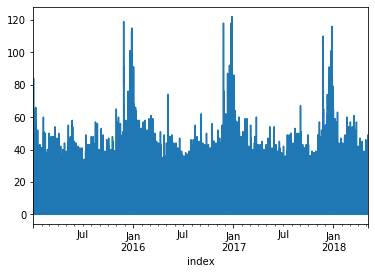

In [11]:
df['Value'].plot()
plt.show()

In [12]:
df.index.min()

Timestamp('2015-01-01 10:00:00')

In [13]:
df.index.max()

Timestamp('2018-05-06 21:00:00')

We can set aside 20% of the data points for test set and training on the remaining 80%.
The cutoff point will be September 2017 as that equates roughly to 80% of our available datapoints.

In [14]:
# Set train/test time split

train_start = pd.to_datetime('20150101 1000', format='%Y-%m-%d %H:%M')
test_start  = pd.to_datetime('20170901 0000', format='%Y-%m-%d %H:%M')
 
train_end   = test_start
test_end    = pd.to_datetime('20180506 2100', format='%Y-%m-%d %H:%M')  

# Assign train/test data frames
df_training = df.loc[:test_start]
df_test     = df.loc[test_start:]

In [15]:
# Determine baseline SARIMA parameters from the latest ACF & PACF
# (24-hour shift, then 1 more shift)

p = 6  # lag from PACF
d = 1  # non-seasonal differences taken to get stationarity
q = 7  # lag from ACF
m = 24 # cycle repeats after 24 hours
P = 2  # 2 if in PACF 24 & 48 are significant
D = 1  # follows d
Q = 2  # 2 if in ACF 24 & 48 are significant

# Investigate Autocorrelation (ACF) and Partial Autocorrelation (PACF) 

In [16]:
data = df[train_start:test_start]

In [17]:
data = data['Value']

In [18]:
data

index
2015-01-01 10:00:00     8.0
2015-01-01 11:00:00    14.0
2015-01-01 12:00:00    28.0
2015-01-01 13:00:00    33.0
2015-01-01 14:00:00    47.0
                       ... 
2017-08-31 20:00:00     6.0
2017-08-31 21:00:00     0.0
2017-08-31 22:00:00     0.0
2017-08-31 23:00:00     0.0
2017-09-01 00:00:00     0.0
Name: Value, Length: 23367, dtype: float64

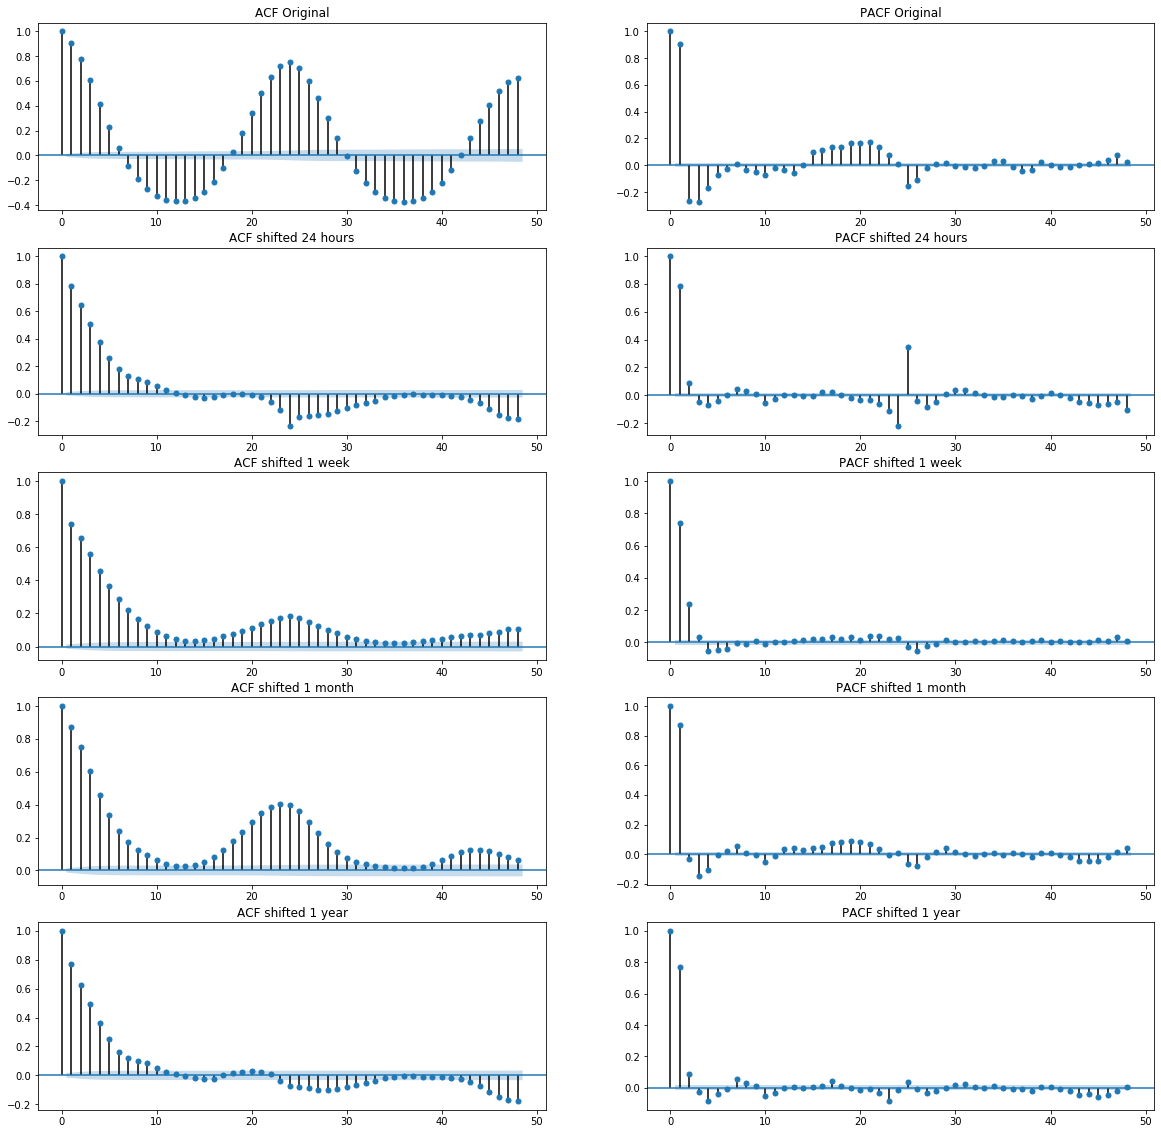

In [19]:

# Zoom in lags over 2 days
lags = 24*2 # hours
one_day = pd.Timedelta(hours=24)

data_shift_day  = data - data.shift(24)
data_shift_week = data - data.shift(24*7)
data_shift_month = data - data.shift(24*30)
data_shift_year = data - data.shift(24*365)

# Adjust time window since shifted data has null values at the start
data_shift_day_p  = data_shift_day[train_start + one_day:]
data_shift_week_p = data_shift_week[train_start + one_day * 7:]
data_shift_monthly_p = data_shift_month[train_start + one_day * 30:]
data_shift_year_p = data_shift_year[train_start + one_day * 365:]



# # Plot ACF & PCF
fig, axes = plt.subplots(ncols=2, nrows=5, figsize=(20,20))
plot_acf (data, lags=lags, ax=axes.flat[0], title='ACF Original')
plot_pacf(data, lags=lags, ax=axes.flat[1], title='PACF Original')
plot_acf (data_shift_day_p, lags=lags, ax=axes.flat[2], title='ACF shifted 24 hours')
plot_pacf(data_shift_day_p, lags=lags, ax=axes.flat[3], title='PACF shifted 24 hours')
plot_acf (data_shift_week_p, lags=lags, ax=axes.flat[4], title='ACF shifted 1 week')
plot_pacf(data_shift_week_p, lags=lags, ax=axes.flat[5], title='PACF shifted 1 week')
plot_acf (data_shift_monthly_p, lags=lags, ax=axes.flat[6], title='ACF shifted 1 month')
plot_pacf(data_shift_monthly_p, lags=lags, ax=axes.flat[7], title='PACF shifted 1 month')
plot_acf (data_shift_year_p, lags=lags, ax=axes.flat[8], title='ACF shifted 1 year')
plot_pacf(data_shift_year_p, lags=lags, ax=axes.flat[9], title='PACF shifted 1 year');




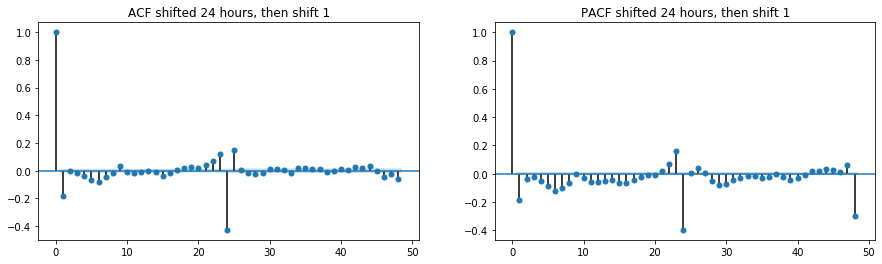

In [20]:
# Now shift the 24-hour shift by 1 since ACF is not decaying fast
data_shift_day1   = data_shift_day - data_shift_day.shift(1)
data_shift_day1_p  = data_shift_day1[train_start + one_day + pd.Timedelta(hours=1):]

# Replot ACF & PCF
fig, axes = plt.subplots(ncols=2, figsize=(15,4))
plot_acf (data_shift_day1_p, lags=lags, ax=axes.flat[0], title='ACF shifted 24 hours, then shift 1')
plot_pacf(data_shift_day1_p, lags=lags, ax=axes.flat[1], title='PACF shifted 24 hours, then shift 1');


# Baseline SARIMA Model

In [21]:
# Determine baseline SARIMA parameters from the latest ACF & PACF
# (24-hour shift, then 1 more shift)

p = 6  # lag from PACF
d = 1  # non-seasonal differences taken to get stationarity
q = 7  # lag from ACF
m = 24 # cycle repeats after 24 hours
P = 2  # 2 if in PACF 24 & 48 are significant
D = 1  # follows d
Q = 2  # 2 if in ACF 24 & 48 are significant

In [ ]:
# Adding seasonality for stakeholders

model = SARIMAX(data,order=(7, 1, 6),seasonal_order=(2, 1, 2, 24)
                ,trend='t',
                enforce_stationarity=False,enforce_invertibility=False)
output = model.fit()
output.summary()

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
